<h1><center>Определение перспективного тарифа для телеком компании</center></h1>

## Оглавление
* [Описание проекта](#first-bullet)
* [Описание данных](#second-bullet)
* [Шаг 1. Изучение общей информации и подготовка данных](#third-bullet)
* [Шаг 2. Анализ данных](#fourth-bullet)
* [Шаг 3. Проверка гипотез](#fifth-bullet)
* [Общий вывод](#sixth-bullet)

## Описание проекта <a class="anchor" id="first-bullet"></a>

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно произвести сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


#### Описание тарифов:

#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей


Учесть: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Описание данных <a class="anchor" id="second-bullet"></a>

#### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

#### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Импортируем все библиотеки, которые потребуются для анализа:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Изучение общей информации и подготовка данных <a class="anchor" id="third-bullet"></a>

#### Посмотрим на доступные для анализа данные

Посмотрим на файл calls.

In [2]:
df_calls = pd.read_csv('calls.csv')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Здесь нам для дальнейшей работы понадобится call_date и duration, но тк тариф у нас оплачивается раз в месяц - то разбивка по точной дате нас не интересует, интересует группировка длительности звонков каждого клиента по месяцам.

In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')

In [5]:
df_calls['call_date_month'] = df_calls['call_date'].dt.month
df_calls.head()

,id,call_date,duration,user_id,call_date_month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


В столбце duration есть довольно много нулей - я полагаю, что это зафиксированные факты попытки связи с другим абонентом, которые не были успешными (то есть абонент, которому пытались дозвониться не ответил). Но тк система (весь технический процесс звонка одного абонента другому со стороны оператора) все равно работала, то оператор все равно снимает за это минимальную сумму, а тк мы знаем, что "Мегалайн" всегда округляет вверх значения минут и мегабайтов, то этой минимальной суммой здесь будет 1 минута. Поэтому заменим все нули в данном столбце на единички.

In [6]:
df_calls['duration'] = df_calls['duration'].replace(0,1)
df_calls.head()

,id,call_date,duration,user_id,call_date_month
0,1000_0,2018-07-25,1.00,1000,7
1,1000_1,2018-08-17,1.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


Для правильно тарификации нужно все числа в duration, у которых есть дробная часть, округлить до следующего целого.

In [7]:
df_calls['duration'] = np.ceil(df_calls['duration'])

Теперь сгруппируем все данные по пользователям и месяцам и вычислим сколько звонков было сделано каждый месяц каждым пользователем и сколько в сумме они потратили минут в месяц.

In [8]:
df_calls_grouped = df_calls.groupby(by = ['user_id', 'call_date_month'])['duration'].agg(['count','sum'])
df_calls_grouped.head()

count    sum
user_id call_date_month              
1000    5                   22  164.0
        6                   43  187.0
        7                   47  346.0
        8                   52  418.0
        9                   58  478.0

Теперь у нас есть таблица по всем клиентам по тому сколько они тратили минут разговора в месяц.

Посмотрим на данные об использовании интернета - файл internet.

In [9]:
df_internet = pd.read_csv('internet.csv', index_col=0)
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Приведем данные в порядок: нужно привести столбец session_date к типу datetime, выделить из него месяц и перевести Мб в Гб (1Гб = 1024 Мб), тк тарификация у нас в них.

In [11]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [12]:
df_internet['session_date_month'] = df_internet['session_date'].dt.month
df_internet.head()

,id,mb_used,session_date,user_id,session_date_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [13]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet.head()

,id,mb_used,session_date,user_id,session_date_month
0,1000_0,113.0,2018-11-25,1000,11
1,1000_1,1053.0,2018-09-07,1000,9
2,1000_2,1198.0,2018-06-25,1000,6
3,1000_3,551.0,2018-08-22,1000,8
4,1000_4,303.0,2018-09-24,1000,9


In [14]:
df_internet['gb_used'] = df_internet['mb_used']/1024
df_internet.head()

,id,mb_used,session_date,user_id,session_date_month,gb_used
0,1000_0,113.0,2018-11-25,1000,11,0.110352
1,1000_1,1053.0,2018-09-07,1000,9,1.028320
2,1000_2,1198.0,2018-06-25,1000,6,1.169922
3,1000_3,551.0,2018-08-22,1000,8,0.538086
4,1000_4,303.0,2018-09-24,1000,9,0.295898


Теперь сгруппируем данные по пользователям и месяцам.

In [15]:
df_internet_grouped = df_internet.groupby(by = ['user_id', 'session_date_month'])['gb_used'].sum()
df_internet_grouped.head()

user_id  session_date_month
1000     5                      2.203125
         6                     22.711914
         7                     13.687500
         8                     13.740234
         9                     14.239258
Name: gb_used, dtype: float64

Далее посмотрим на файл с сообщениями (messages).

In [16]:
df_messages = pd.read_csv('messages.csv')
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Здесь нам тоже нужны кол-во сообщений по месяцам, поэтому приведем сначала message_date к типу datetime, а потом выделим месяцы и объединим информацию по пользователям и месяцам.

In [18]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')

In [19]:
df_messages['message_date_month'] = df_messages['message_date'].dt.month
df_messages.head()

,id,message_date,user_id,message_date_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [20]:
df_messages_grouped = df_messages.groupby(by = ['user_id', 'message_date_month'])['id'].count()
df_messages_grouped

user_id  message_date_month
1000     5                     22
         6                     60
         7                     75
         8                     81
         9                     57
                               ..
1498     10                    42
1499     9                     11
         10                    48
         11                    59
         12                    66
Name: id, Length: 2717, dtype: int64

Посмотрим на файл с тарифами.

In [21]:
df_tariffs = pd.read_csv('tariffs.csv')
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Здесь все нужное, ничего лишнего, поэтому оставим все как есть.

Посмотрим на файл с информацией о пользователях (users).

In [23]:
df_users = pd.read_csv('users.csv')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [24]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице users нужно изменить тип данных: churn_date и reg_date преобразовать из object в datetime.

In [25]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')

In [26]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')

In [27]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Все таблицы предобработаны.

Теперь создадим общую таблицу с данными - total_data и соединим в ней все нужные для анализа данные. 

Для начала соединим таблицы users и messages.

In [28]:
df_messages_grouped = df_messages_grouped.reset_index()
df_messages_grouped.head()

,user_id,message_date_month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [29]:
df_messages_grouped.columns = ['user_id', 'message_date_month', 'message_count']


In [30]:
df_messages_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   user_id             2717 non-null   int64
 1   message_date_month  2717 non-null   int64
 2   message_count       2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


In [31]:
total_data = pd.merge(df_users, df_messages_grouped, how='left', left_on = 'user_id', right_on = 'user_id')
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,message_date_month,message_count
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0


Теперь соединим получившуюся таблицу с df_calls_grouped по тому же принципу, но теперь кроме user_id также будем использовать соединение по месяцу.

In [32]:
total_data = pd.merge(total_data, df_calls_grouped, how='left', left_on = ['user_id', 'message_date_month'], right_on = ['user_id', 'call_date_month'])
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,message_date_month,message_count,count,sum
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,22.0,164.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,43.0,187.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,47.0,346.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,52.0,418.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,58.0,478.0


In [33]:
total_data.columns


Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'message_date_month', 'message_count', 'count',
       'sum'],
      dtype='object')

In [34]:
total_data.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 'month', 'message_count','number_of_calls', 'call_duration']

Прибавили таблицу calls и переименовали колонки для понятности. Теперь присоединим таблицу df_internet_grouped.

In [35]:
df_internet_grouped = df_internet_grouped.reset_index()
df_internet_grouped.head()

,user_id,session_date_month,gb_used
0,1000,5,2.203125
1,1000,6,22.711914
2,1000,7,13.687500
3,1000,8,13.740234
4,1000,9,14.239258


In [36]:
total_data = pd.merge(total_data, df_internet_grouped, how='left', left_on = ['user_id', 'month'], right_on = ['user_id', 'session_date_month'])
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,message_count,number_of_calls,call_duration,session_date_month,gb_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,22.0,164.0,5.0,2.203125
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,43.0,187.0,6.0,22.711914
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,47.0,346.0,7.0,13.687500
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,52.0,418.0,8.0,13.740234
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,58.0,478.0,9.0,14.239258


In [37]:
total_data.drop(['session_date_month'], axis='columns', inplace=True)
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,message_count,number_of_calls,call_duration,gb_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,22.0,164.0,2.203125
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,43.0,187.0,22.711914
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,47.0,346.0,13.687500
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,52.0,418.0,13.740234
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,58.0,478.0,14.239258


In [38]:
total_data = pd.merge(total_data, df_tariffs, how='left', left_on = 'tariff', right_on = 'tariff_name')
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,message_count,...,call_duration,gb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,...,164.0,2.203125,1000,30720,3000,1950,150,1,1,ultra
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,...,187.0,22.711914,1000,30720,3000,1950,150,1,1,ultra
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,...,346.0,13.687500,1000,30720,3000,1950,150,1,1,ultra
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,...,418.0,13.740234,1000,30720,3000,1950,150,1,1,ultra
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,...,478.0,14.239258,1000,30720,3000,1950,150,1,1,ultra


#### Итак, для каждого пользователя посчитано:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

Теперь посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану).

In [39]:
total_data['calls_over_traffic'] = total_data['call_duration'] - total_data['minutes_included']
total_data['messages_over_traffic'] = total_data['message_count'] - total_data['messages_included']
total_data['internet_gb_over_traffic'] = total_data['gb_used'] - (total_data['mb_per_month_included']/1024)
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,message_count,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,calls_over_traffic,messages_over_traffic,internet_gb_over_traffic
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,...,30720,3000,1950,150,1,1,ultra,-2836.0,-978.0,-27.796875
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,...,30720,3000,1950,150,1,1,ultra,-2813.0,-940.0,-7.288086
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,...,30720,3000,1950,150,1,1,ultra,-2654.0,-925.0,-16.312500
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,...,30720,3000,1950,150,1,1,ultra,-2582.0,-919.0,-16.259766
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,...,30720,3000,1950,150,1,1,ultra,-2522.0,-943.0,-15.760742


In [40]:
def calculate_revenue(row):
    revenue = 0
    if row['calls_over_traffic']>0:
        revenue = (abs(row['calls_over_traffic']))*row['rub_per_minute']
    if row['messages_over_traffic']>0:
        revenue += (abs(row['messages_over_traffic']))*row['rub_per_message'] 
    if row['internet_gb_over_traffic']>0:
        revenue += (abs(row['internet_gb_over_traffic']))*row['rub_per_gb']
    return revenue + row['rub_monthly_fee']

total_data['revenue'] = total_data.apply(calculate_revenue, axis = 1)
total_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,message_count,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,calls_over_traffic,messages_over_traffic,internet_gb_over_traffic,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,...,3000,1950,150,1,1,ultra,-2836.0,-978.0,-27.796875,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,60.0,...,3000,1950,150,1,1,ultra,-2813.0,-940.0,-7.288086,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,75.0,...,3000,1950,150,1,1,ultra,-2654.0,-925.0,-16.312500,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,81.0,...,3000,1950,150,1,1,ultra,-2582.0,-919.0,-16.259766,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,57.0,...,3000,1950,150,1,1,ultra,-2522.0,-943.0,-15.760742,1950.0


In [41]:
total_data.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'month', 'message_count', 'number_of_calls',
       'call_duration', 'gb_used', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name',
       'calls_over_traffic', 'messages_over_traffic',
       'internet_gb_over_traffic', 'revenue'],
      dtype='object')

### Вывод

В этом разделе:
- была изучена общая информация о данных;
- обработаны ошибки, например: звонки с нулевой длительностью звонка были заменены на звонки длительностью в одну минуту, остальные дробные дробные длительности звонков и Мб интернет данных были округлены до ближайшего целого числа, тк так их считает оператор, а также Мб были переведены в Гб, тк в них рассчитывается тариф;
- данные из всех таблиц были объединены в одну таблицу, лишние данные удалены;
- для каждого пользователя было рассчитано: 

    1) количество сделанных звонков и израсходованных минут разговора по месяцам;

    2) количество отправленных сообщений по месяцам;

    3) объем израсходованного интернет-трафика по месяцам;

    4) помесячная выручка с каждого пользователя.

Все данные были записаны в таблицу для дальнейшего анализа.

## Шаг 2. Анализ данных <a class="anchor" id="fourth-bullet"></a>

Теперь, когда данные подготовленны, можно исходя из них посмотреть на поведение клиентов оператора.
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? (посчитаем среднее количество, дисперсию и стандартное отклонение, построим гистограммы и опишем распределения).

In [42]:
total_data.groupby(by = 'tariff')[('message_count','call_duration','gb_used')].agg(['mean','std','var'])

message_count                         call_duration              \
                mean        std          var          mean         std   
tariff                                                                   
smart      38.716441  26.787949   717.594201    432.437891  192.366786   
ultra      61.161006  45.931026  2109.659183    567.350394  320.245433   

                         gb_used                       
                  var       mean       std        var  
tariff                                                 
smart    37004.980475  15.883658  5.657711  32.009692  
ultra   102557.137247  19.180734  9.365159  87.706206

#### Посмотрим на распределение кол-ва отправленных сообщений по тарифам:

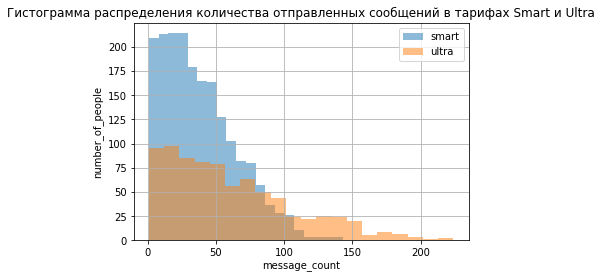

In [43]:
for tariff, d in total_data.groupby(by = 'tariff'):
    d['message_count'].hist(bins=20,alpha = 0.5, label=tariff)
plt.xlabel('message_count')
plt.ylabel('number_of_people')
plt.title('Гистограмма распределения количества отправленных сообщений в тарифах Smart и Ultra')
plt.legend()
plt.show();

Оба распределения с положительной ассиметрией, то есть правый "хвост" распределений значительно длиннее левого.

In [44]:
print('Процент пользователей тарифа smart, которые используют большее кол-во сообщений, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='smart', 'message_count'] > 50).mean()))

Процент пользователей тарифа smart, которые используют большее кол-во сообщений, чем предоставлено в тарифе: 28.61%


In [45]:
print('Процент пользователей тарифа ultra, которые используют большее кол-во сообщений, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='ultra', 'message_count'] > 1000).mean()))

Процент пользователей тарифа ultra, которые используют большее кол-во сообщений, чем предоставлено в тарифе: 0.00%


#### Теперь посмотрим на распределение общей длительности звонков по тарифам:

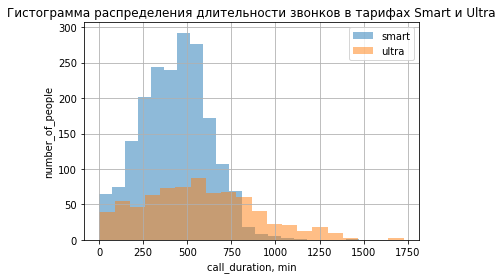

In [46]:
for tariff, d in total_data.groupby(by = 'tariff'):
    d['call_duration'].hist(bins=20,alpha = 0.5, label=tariff)
plt.xlabel('call_duration, min')
plt.ylabel('number_of_people')
plt.title('Гистограмма распределения длительности звонков в тарифах Smart и Ultra')
plt.legend()

Распределение похоже на нормальное, немного скошенное в положительную сторону (то есть его правый "хвост" длиннее левого).

In [47]:
print('Процент пользователей тарифа smart, которые используют большее кол-во минут разговора, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='smart', 'call_duration'] > 500).mean()))

Процент пользователей тарифа smart, которые используют большее кол-во минут разговора, чем предоставлено в тарифе: 36.17%


In [48]:
print('Процент пользователей тарифа ultra, которые используют большее кол-во минут разговора, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='ultra', 'call_duration'] > 3000).mean()))

Процент пользователей тарифа ultra, которые используют большее кол-во минут разговора, чем предоставлено в тарифе: 0.00%


#### А также посмотрим на распределение кол-ва израсходанного интернет-трафика по тарифам:

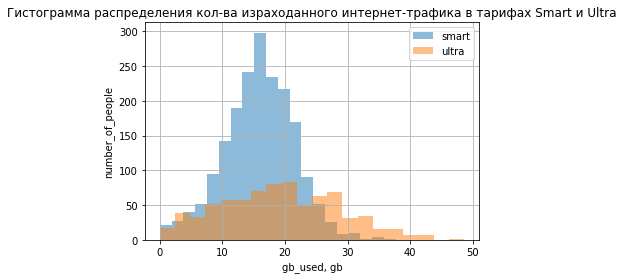

In [49]:
for tariff, d in total_data.groupby(by = 'tariff'):
    d['gb_used'].hist(bins=20,alpha = 0.5, label=tariff)
plt.xlabel('gb_used, gb')
plt.ylabel('number_of_people')
plt.title('Гистограмма распределения кол-ва израходанного интернет-трафика в тарифах Smart и Ultra')
plt.legend()

In [50]:
print('Процент пользователей тарифа smart, которые используют большее кол-во интернет-трафика, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='smart', 'gb_used'] > 15).mean()
))

Процент пользователей тарифа smart, которые используют большее кол-во интернет-трафика, чем предоставлено в тарифе: 57.08%


In [51]:
print('Процент пользователей тарифа ultra, которые используют большее кол-во интернет-трафика, чем предоставлено в тарифе: {:.2%}'.format((total_data.loc[total_data['tariff']=='ultra', 'gb_used'] > 30).mean()))

Процент пользователей тарифа ultra, которые используют большее кол-во интернет-трафика, чем предоставлено в тарифе: 11.83%


### Вывод

По полученным показателям и графикам видно, что:

1) Кол-во сообщений. Для тарифа smart кол-во включенных в тариф сообщений - 50, а для тарифа ultra - 1000. Пользователи тарифа smart в 28% случаев превышают лимит указанный в тарифе, что довольно много - практически треть всех пользователей. В тарифе ультра никто не тратит больше чем 1000 сообщений в месяц - в таких кол-вах сообщения пользователям просто не нужны, кажется что они используются исключительно в целях использования больших = впечатляющих цифр в маркетинговых компаниях.

2) Общая длительность звонков. Для тарифа smart кол-во включенных в тариф минут разговора - 500, а для тарифа ultra - 3000. Пользователи тарифа smart превышают лимит тарифа в 36%, а пользователи ultra никогда не говорят больше 3000 минут.

3) Кол-во издасходанного интернет-трафика. Для тарифа smart кол-во включенного интернет-трафика - 15Гб, а для тарифа ultra - 30Гб. Пользователи тарифа smart почти в 59% случаев превышают лимит указанный в тарифе, а пользователи тарифа ultra в 13% случаев.

#### Общий вывод: 
Довольно внушительный процент пользователей тарифа smart очень часто превышают лимиты тарифа по всем трем параметрам: по длительности звонков, по кол-ву сообщений и по использованному интернет-трафику. Пользователи тарифа ultra превышают трафик только в использованию интернета и то всего в 13% случаев. То есть по тарифу smart оператор зарабатывает довольно много на допольнительных услугах (сверх тарифного плана), а на пользователях тарифа ultra основной доход составляет стоимость самого тарифа.

## Шаг 3. Проверка гипотез <a class="anchor" id="fifth-bullet"></a>

4.1 Как видно из анализа выше, тарифы предназначены для разных типов аудиторий - под разные нужды, и оператор зарабатывает на каждом из тарифов разными способами: пользователи тарифа smart часто превышают лимиты тарифа (который сам по себе стоит 550 рублей в месяц), и оператор зарабытывает на услугах сверх тарифного пакета, в то время как тариф ultra сам по себе стоит сильно дороже (1950 рублей в месяц, но его пользователи почти не выходят за пределы тарифного плана, а значит основной заработок оператора - стоимость тарифа в месяц.

Интересно посмотреть различается ли средняя выручка в этих тарифных планах или операторы зарабатывают на всех одинакого, просто разными способами.

#### Наша нулевая гипотеза:

Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равна (не различается).

#### И альтернативная гипотеза:

Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается. 

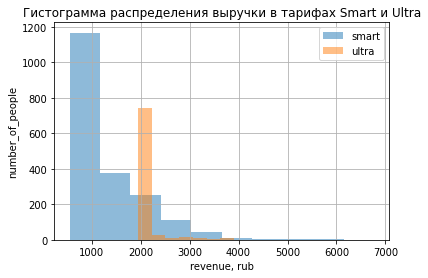

In [52]:
for tariff, d in total_data.groupby(by = 'tariff'):
    d['revenue'].hist(bins=10,alpha = 0.5, label=tariff)
plt.xlabel('revenue, rub')
plt.ylabel('number_of_people')
plt.title('Гистограмма распределения выручки в тарифах Smart и Ultra')
plt.legend()

In [53]:
(total_data.loc[total_data['tariff']=='smart', 'revenue']).mean()

1232.679671645104

In [54]:
(total_data.loc[total_data['tariff']=='ultra', 'revenue']).mean()

2036.7596584413109

In [55]:
data1 = total_data.loc[total_data['tariff']=='smart', 'revenue']
data2 = total_data.loc[total_data['tariff']=='ultra', 'revenue']
alpha = 0.05

results = st.ttest_ind(
    data1,
    data2,
    equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 2.6080075636521516e-259
Отвергаем нулевую гипотезу


Тк мы отвергли нулевую гипотезу, то мы можем сказать, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается (тк это наша альтернативная гипотеза).

4.2 В предыдущем шаге мы рассматривали всех пользователей из выборки и делили их по тому какой тариф они используют.
Может быть выручка операторов также зависит от места жительства пользователей. Попробуем сравнить выручку пользователей из Москвы от выручки пользователей других регионов.

#### Нашей нулевой гипотезой будет предположение, что: 

Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

#### А альтернативной гипотезой будет предположение, что:

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [56]:
data3 = total_data.loc[total_data['city'] == 'Москва', 'revenue']
data4 = total_data.loc[total_data['city'] != 'Москва', 'revenue']
alpha = 0.05

results = st.ttest_ind(
    data3,
    data4,
    equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.23957075943108902
Не удалось отвергнуть нулевую гипотезу


Нам не удалось отвергнуть нулевую гипотезу, а значит мы не можем опровергнуть, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

### Вывод

Мы проверили две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Первая гипотеза подтвердилась, а вторая нет (то есть нам не удалось опровергнуть нулевую гипотезу о равенстве выручки в Москве и в других регионах).

## Общий вывод <a class="anchor" id="sixth-bullet"></a>

В этой работе были рассмотрены два тарифных плана оператора «Мегалайн»: «Смарт» и «Ультра».

Цель была понять какой тариф приносит больше денег оператору, чтобы на основе этого знания скорректировать рекламный бюджет.

Анализ был проведен по данным 500 пользователей «Мегалайна» за 2018 год.

В первом и втором разделе была изучена общая информация о данных, обработаны ошибки, все данные объединены в одну таблицу, и для каждого пользователя рассчитано: количество сделанных звонков, израсходованных минут разговора, количество отправленных сообщений и объем израсходованного интернет-трафика по месяцам, а также омесячная выручка с каждого пользователя.

Во третьем разделе был проведен анализ данных и сделан вывод, что: довольно внушительный процент пользователей тарифа smart очень часто превышают лимиты тарифа по всем трем параметрам: по длительности звонков, по кол-ву сообщений и по использованному интернет-трафику. Пользователи тарифа ultra превышают трафик только в использованию интернета и то всего в 13% случаев. То есть по тарифу smart оператор зарабатывает довольно много на допольнительных услугах (сверх тарифного плана), а на пользователях тарифа ultra основной доход составляет стоимость самого тарифа.

И в четвертом разделе была проведена проверка двух гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Первая гипотеза подтвердилась, а вторая нет (то есть нам не удалось опровергнуть нулевую гипотезу о равенстве выручки в Москве и в других регионах).